<h3>Upload Data</h3>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/trying"

In [ ]:
%cd /content/drive/MyDrive/trying
!ls -a

/content/drive/MyDrive/trying
Untitled2.ipynb


In [ ]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

brain-tumor-classification-mri.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import os
import zipfile

local_zip = 'brain-tumor-classification-mri.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
%cd '/tmp/'
!ls -a

/tmp
.
..
dap_multiplexer.89def72c6365.root.log.INFO.20211101-024717.57
dap_multiplexer.INFO
debugger_12wenpu1mf
drivefs_ipc.0
drivefs_ipc.0_shell
initgoogle_syslog_dir.0
Testing
tmppe3u_uj7
Training


In [ ]:
train_dir = '/tmp/Training'
gli_train_dir = train_dir + '/glioma_tumor'
men_train_dir = train_dir + '/meningioma_tumor'
no_train_dir  = train_dir + '/no_tumor'
pit_train_dir = train_dir + '/pituitary_tumor'

test_dir = '/tmp/Testing'
gli_test_dir = test_dir + '/glioma_tumor'
men_test_dir = test_dir + '/meningioma_tumor'
no_test_dir  = test_dir + '/no_tumor'
pit_test_dir = test_dir + '/pituitary_tumor'

In [ ]:
print("Training")
print("Total Training Glioma Tumor     :", len(os.listdir(gli_train_dir)))
print("Total Training Meningioma Tumor :", len(os.listdir(men_train_dir)))
print("Total Training No Tumor         :", len(os.listdir(no_train_dir)))
print("Total Training Pituitary_Tumor  :", len(os.listdir(pit_train_dir)))
print("Testing")
print("Total Testing Glioma Tumor     :", len(os.listdir(gli_test_dir)))
print("Total Testing Meningioma Tumor :", len(os.listdir(men_test_dir)))
print("Total Testing No Tumor         :", len(os.listdir(no_test_dir)))
print("Total Testing Pituitary_Tumor  :", len(os.listdir(pit_test_dir)))

Training
Total Training Glioma Tumor     : 826
Total Training Meningioma Tumor : 822
Total Training No Tumor         : 395
Total Training Pituitary_Tumor  : 827
Testing
Total Testing Glioma Tumor     : 100
Total Testing Meningioma Tumor : 115
Total Testing No Tumor         : 105
Total Testing Pituitary_Tumor  : 74


In [ ]:
import cv2
import numpy as np

In [ ]:
def gather_data(data_dir):
    dir_data = []
    dir_label = []

    for dirpath, dirnames, filenames in os.walk(data_dir):
        for file in filenames:
            if ".jpg" in file:
                imagePath = os.path.join(dirpath, file)
                image = cv2.imread(imagePath)
                image = cv2.resize(image, (150,150))
                dir_data.append(image)
                label = imagePath.split(os.path.sep)[-2]
                dir_label.append(label)

    dir_data = np.array(dir_data)
    dir_label = np.array(dir_label)

    return dir_data, dir_label

<h3>Data Preprocessing</h3>

In [ ]:
train_data, train_label = gather_data(train_dir) # Gather data train
test_data, test_label = gather_data(test_dir) # Gather data test

In [ ]:
print("Train Data  = ", train_data.shape)
print("Train Label = ", train_label.shape)
print("Test Data   = ", test_data.shape)
print("Test Label  = ", test_label.shape)

Train Data  =  (2870, 150, 150, 3)
Train Label =  (2870,)
Test Data   =  (394, 150, 150, 3)
Test Label  =  (394,)


In [ ]:
print("Data sebelum di-normalisasi ", test_data[0][0][0])

x_test = test_data.astype('float32') / 255.0
x_train = train_data.astype('float32') / 255.0
print("Data setelah di-normalisasi ", x_test[0][0][0])

Data sebelum di-normalisasi  [0 0 0]
Data setelah di-normalisasi  [0. 0. 0.]


In [ ]:
from sklearn.preprocessing import LabelEncoder

print("Label sebelum di-encoder ", train_label[995:1005])

lb = LabelEncoder()
y_train = lb.fit_transform(train_label)
y_test = lb.fit_transform(test_label)

print("Label setelah di-encoder ", y_train[995:1005])

Label sebelum di-encoder  ['no_tumor' 'no_tumor' 'no_tumor' 'no_tumor' 'no_tumor' 'no_tumor'
 'no_tumor' 'no_tumor' 'no_tumor' 'no_tumor']
Label setelah di-encoder  [2 2 2 2 2 2 2 2 2 2]


<h3>Definisikan Model</h3>

In [ ]:
import tensorflow

In [ ]:
y_train = tensorflow.keras.utils.to_categorical(y_train, 4)
y_test = tensorflow.keras.utils.to_categorical(y_test, 4)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Flatten, BatchNormalization, Activation

In [ ]:
# Buat model dengan 1 input layer, 1 hidden layer, dan 1 output layer
img_input = layers.Input(shape=(150, 150, 3)) # layer input
x = layers.Flatten()(img_input) # ubah dari matriks 150x150x3 menjadi vektor
x = layers.Dense(128, activation='relu')(x) # hidden layer 1 dengan 128 neuron
output = layers.Dense(4, activation='softmax')(x) # output layer dengan 1 neuron (binary)

# Definisikan modelnya
model = Model(img_input, output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 67500)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               8640128   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 8,640,644
Trainable params: 8,640,644
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import tensorflow as tf
from tensorflow.keras import callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc')> 0.90):
      print("\nAkurasi validasi telah mencapai >90%!")
      self.model.stop_training = True


callbacks = myCallback()

In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['acc'])

In [ ]:
H = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
90/90 [==============================] - 5s 54ms/step - loss: 0.2193 - acc: 0.9220 - val_loss: 7.0896 - val_acc: 0.6599
Epoch 2/100
90/90 [==============================] - 5s 53ms/step - loss: 0.3666 - acc: 0.8767 - val_loss: 5.1142 - val_acc: 0.6853
Epoch 3/100
90/90 [==============================] - 5s 53ms/step - loss: 0.1512 - acc: 0.9495 - val_loss: 5.7383 - val_acc: 0.6904
Epoch 4/100
90/90 [==============================] - 5s 53ms/step - loss: 0.2394 - acc: 0.9178 - val_loss: 5.7728 - val_acc: 0.6650
Epoch 5/100
90/90 [==============================] - 5s 53ms/step - loss: 0.2251 - acc: 0.9185 - val_loss: 6.2070 - val_acc: 0.6853
Epoch 6/100
90/90 [==============================] - 5s 55ms/step - loss: 0.1362 - acc: 0.9481 - val_loss: 7.2976 - val_acc: 0.6827
Epoch 7/100
90/90 [==============================] - 5s 54ms/step - loss: 0.1194 - acc: 0.9659 - val_loss: 6.5817 - val_acc: 0.7081
Epoch 8/100
90/90 [==============================] - 5s 55ms/step - loss: 0.

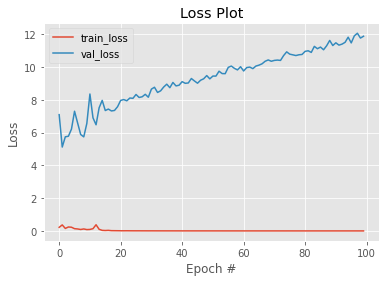

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

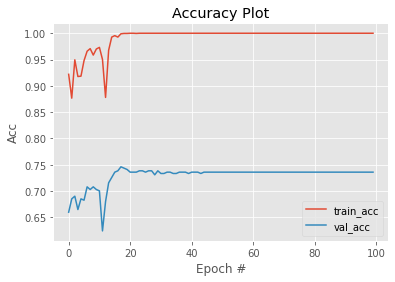

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_acc"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

pred = model.predict(x_train)
labels = (pred > 0.5).astype(np.int)

print(classification_report(y_train, labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       826
           1       1.00      1.00      1.00       822
           2       1.00      1.00      1.00       395
           3       1.00      1.00      1.00       827

   micro avg       1.00      1.00      1.00      2870
   macro avg       1.00      1.00      1.00      2870
weighted avg       1.00      1.00      1.00      2870
 samples avg       1.00      1.00      1.00      2870

